# Estimación de ruido mediante análisis de segmentos

In [3]:
import os
import numpy as np
import json
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from scipy.stats import norm

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Leemos la data extraida del slice

In [7]:
data_path = 'infosaves'
data_dict = {}
hist_dict = {}
for image in os.listdir(data_path):
    for file in os.listdir(os.path.join(data_path, image)):
        if file.endswith('.json'):
            data_dict[image] = json.load(open(os.path.join(data_path, image, file), 'r'))
        elif file.endswith('.csv'):
            hist_dict[image] = pd.read_csv(os.path.join(data_path, image, file))
    print(image)
    print(data_dict[image])
    print(hist_dict[image].columns)
            

Noise-4
{'nombre_img': 'Noise-4', 'x': 34, 'y': -168, 'roi_type': 'line', 'length': 366, 'desv_est': 31.8730047332364, 'mean': 60.08259535094309}
Index(['gray_lvl', 'hist_value'], dtype='object')
Noise-1
{'nombre_img': 'Noise-1', 'x': -39, 'y': 26, 'roi_type': 'line', 'length': 424, 'desv_est': 7.9986517336305765, 'mean': 15.801156203638035}
Index(['gray_lvl', 'hist_value'], dtype='object')
Noise-3
{'nombre_img': 'Noise-3', 'x': 145, 'y': 106, 'roi_type': 'rect', 'height': 193, 'width': 180, 'desv_est': 19.71741327622657, 'mean': 39.5337562046091}
Index(['gray_lvl', 'hist_value'], dtype='object')
Noise
{'nombre_img': 'Noise', 'x': 100, 'y': 100, 'roi_type': 'rect', 'height': 317, 'width': 306, 'desv_est': 15.162231377190754, 'mean': 19.604162800766993}
Index(['gray_lvl', 'hist_value'], dtype='object')
Noise-2
{'nombre_img': 'Noise-2', 'x': -39, 'y': 26, 'roi_type': 'line', 'length': 387, 'desv_est': 11.236040101154472, 'mean': 24.450705268748877}
Index(['gray_lvl', 'hist_value'], dtype

### Reconstruimos el ruido con media y varianza

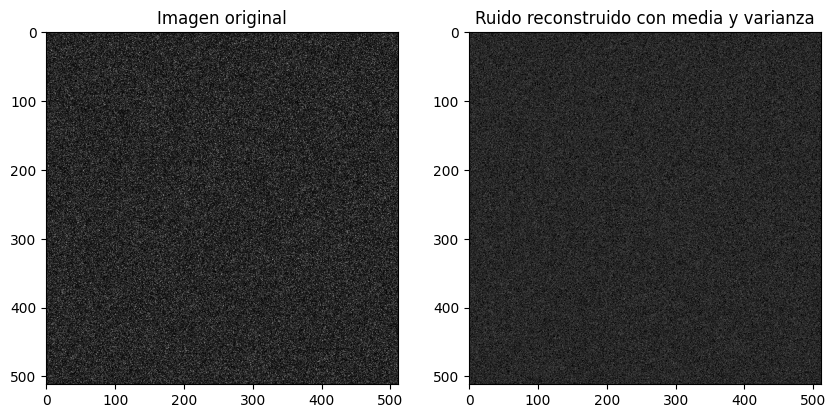

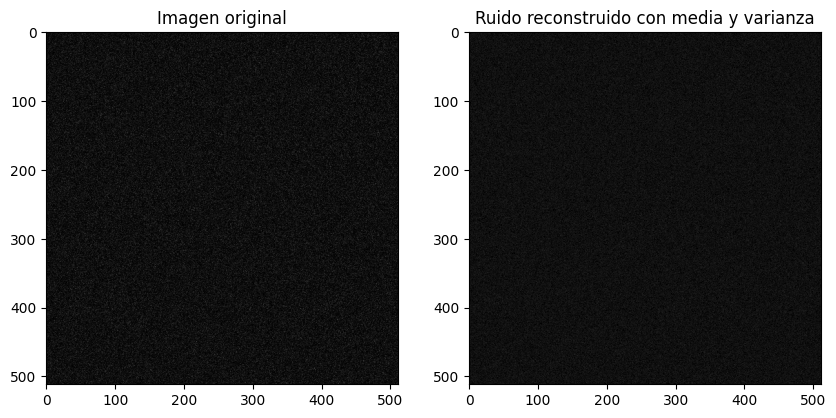

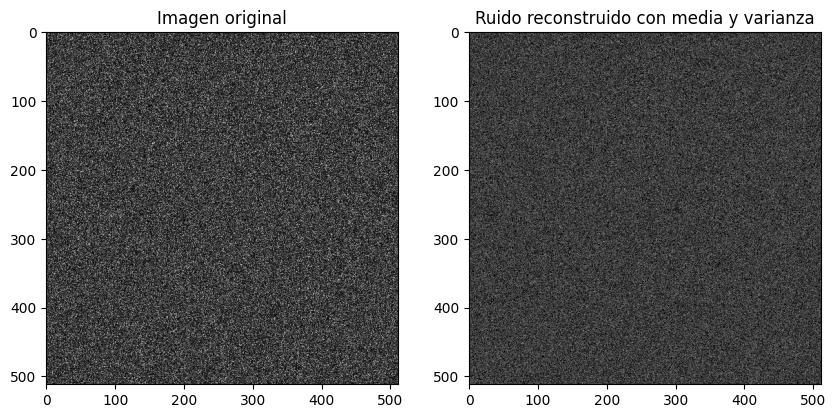

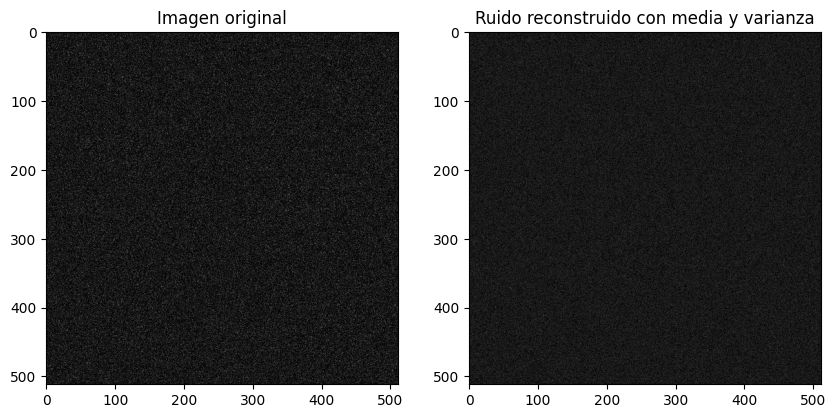

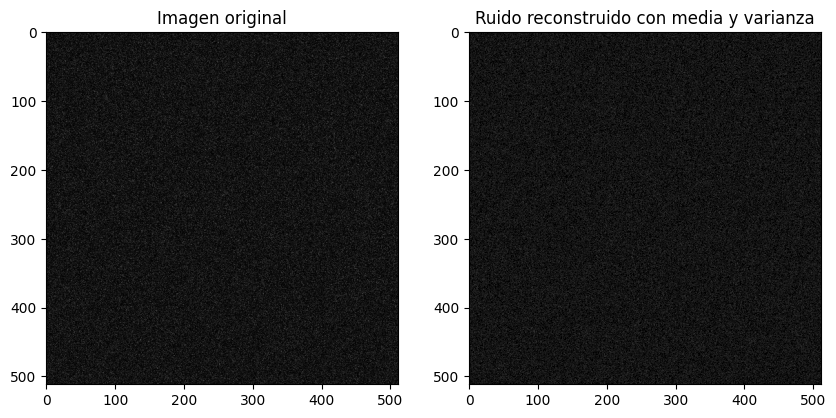

In [12]:
noise_dir = 'PAIByB-1'

for noise in os.listdir(noise_dir):
    ruido_real = cv2.imread(os.path.join(noise_dir, noise), cv2.IMREAD_GRAYSCALE)
    stats = data_dict[noise.split('.')[0]]
    ruido_reconstruido = np.random.normal(loc=stats['mean'], 
                                          scale=stats['desv_est'],
                                          size=ruido_real.shape)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(ruido_real, vmin=0, vmax=255, cmap='gray')
    axs[0].set_title('Imagen original')
    axs[1].imshow(ruido_reconstruido, vmin=0, vmax=255, cmap='gray')
    axs[1].set_title('Ruido reconstruido con media y varianza')
    plt.show()

### Ajuste de distribuciones normales al histograma analizando media y varianza del segmento

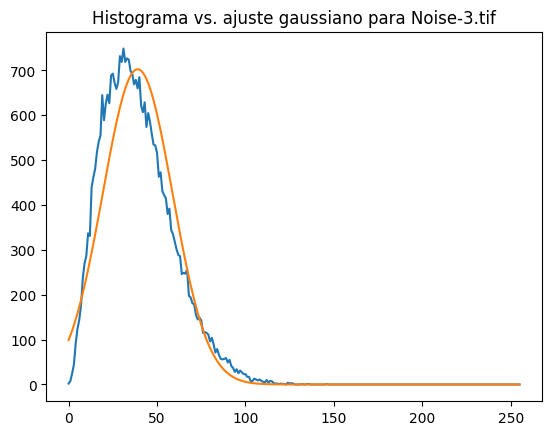

DMA=15.758


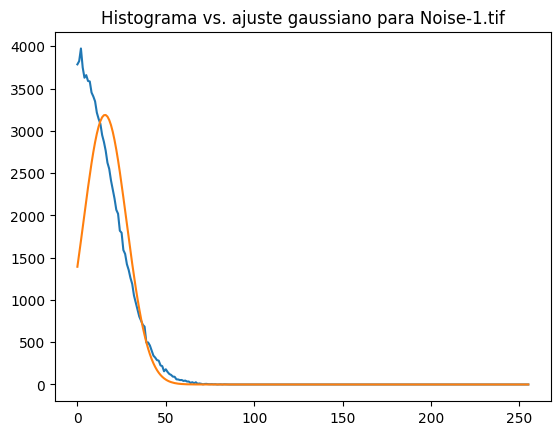

DMA=9.724


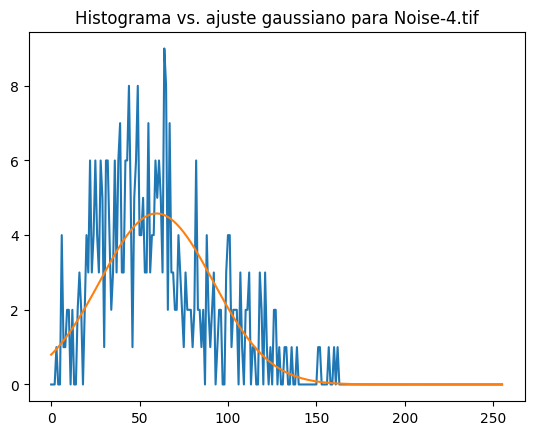

DMA=25.294


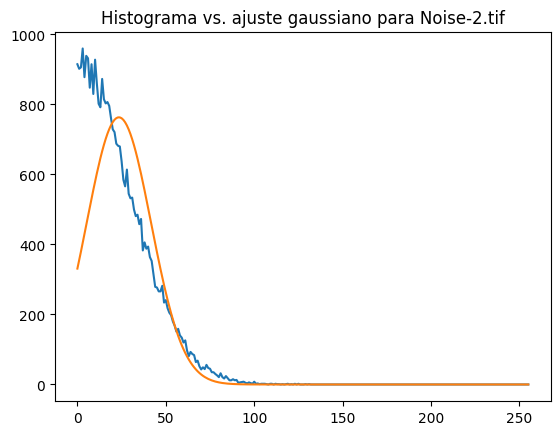

DMA=14.517


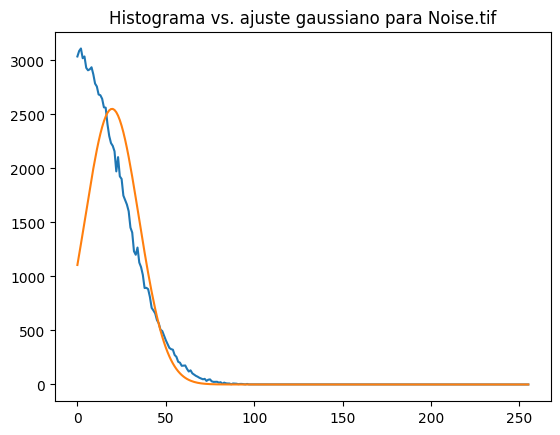

DMA=12.140


In [17]:
for noise in os.listdir(noise_dir):
    hist_df = hist_dict[noise.split('.')[0]]
    I, h = hist_df['gray_lvl'], hist_df['hist_value']
    mu = np.dot(I, h) / h.sum()
    sigma = np.sqrt(np.dot((I - mu)**2, h) / h.sum())
    bell_curve = norm.pdf(x=I, loc=mu, scale=sigma) * h.sum()
    
    fig, ax = plt.subplots()
    ax.plot(hist_df['gray_lvl'], hist_df['hist_value'])
    ax.plot(hist_df['gray_lvl'], bell_curve)
    ax.set_title(f'Histograma vs. ajuste gaussiano para {noise}')
    plt.show()
    
    # Calculo DMA
    # Calculo DMA
    DMA = np.abs(I - mu).dot(h) / h.sum()
    print(f"{DMA=:.3f}")